# Survival models

Survival models are useful for time-to-event scenarios.

Models to try:
1. Pytorch probabilistic model
   1. predicts binary has a customer churned at day N following a treatment
   2. feature is only the number of days since the intervention
   3. and reward is churned by day N or not

Dataset
1. we need to generate days until churn for a set of customers
2. truncate to the reward horizon of day N
3. Features - days since intervention
   1. should we include features that are not relevant to our treatment

Scenario:
1. Assume we are Spotify/Netflix selling a subscription to a music service
2. Customers sign up and cancel or churn at some point in the future
3. We want to predict the number of days until a customer churns

Todo:
1. Model churn rate as not smooth, spikes at different dates.

References:
1. https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html

Setup:
```
uv add lifelines polars numpy seaborn matplotlib scikit-learn
uv add ipykernel --dev
```

## Survival models

When dealing with time to event data we observe censored data. For example an online service measuring the number of days until a customer churns after signing up to a subscription.
The event we are measuring is a customer churning.
If we collect data after 90 days, we observe churns only up to day 90, for anyone that churns after 90 days we do not observe. These unobserved customers are right-censored.

Treating these right-censored the same as those fully observed customers will bias our analysis.
For example averaging the days until churn will always report an underbiased value, as it will never be greater than 90.
Similarly including only observed customers creates a biased dataset, as we are selecting for customers who churned earlier.

We can formulate this as a survival problem. The standard framework is presented as follows:
Given that $T$ is the time an event takes place, survival functions represent the probability of an event happening after a given time:

$$
S(t) = Pr(T>t)
$$

The function must be monotonically decreasing to 0.

The hazard function represents the probability of an event happening at time $t$, given that the event has not yet happened:

$$
h(t) = \mathrm{lim}_{\delta t  \rightarrow 0} \frac{Pr(t<T<t+\delta t|T>t)}{\delta t}
$$

Its also represented as:

$$
h(t) = \frac{-S'(t)}{S(t)}
$$

We can use this to represent the survival function as a function of the hazard function:

$$
\begin{align}
\frac{S'(t)}{S(t)} & = -h(t) &\\
\int \frac{S'(t)}{S(t)} dt & = - \int h(t) dt &\\
\ln |S(t)| & = - \int h(t) dt + C &\\
S(t) & =\exp \left(- \int h(t) dt + C \right)
\end{align}
$$

At $t=0$, $S(t)=1$ as no events have yet happened. Therefore, $C=0$:

$$
S(t)  =\exp \left(- \int_0^t h(u) du \right)
$$

This makes intuitive sense - the survival function at time $t$ is the cumulative sum of hazards up to $t$. Hence the hazard integral has an alternative name, the cumulative hazard, $H(t)$:

$$
S(t)  =\exp \left(- H(t) \right)
$$


In our case the hazard function relates to the risk of churn on any given day.
The survival function is the probability of not having churned yet at a given day.

## Simulating data
First lets create a data generating function.

We simulate customers subscribing and then churning from a subscription service.

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

n_customers = 1000
max_days = 90
np.random.seed(42)

customer_days = np.tile(np.arange(0, max_days), [n_customers, 1])


# Generate churn dates as base churn percent per day + exponentially decaying churn rate since subscription start
def churn_rate_per_day(x):
    return 0.001 + 0.05 * np.exp(-x / 20)


# simulate churn events per day
churn_rates = churn_rate_per_day(customer_days)
churn_events = np.random.binomial(1, churn_rates)
# find first churn event
churn_day_events = (churn_events & (np.cumsum(churn_events, axis=1) == 1)).astype(int)
churn_days = np.argmax(churn_day_events, axis=1) + 1
# if sum of churn_events is 0, set churn_days to max_days
churn_days[churn_day_events.sum(axis=1) == 0] = max_days

df = pl.DataFrame(
    {
        "customer_id": range(n_customers),
        "days_until_churn": churn_days,
        "observed": churn_days < max_days,
    }
)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.head()

customer_id,days_until_churn,observed
i64,i64,bool
29,90,false
535,16,true
695,90,false
557,90,false
836,14,true


We model churn per day as an exponential decay. Where we see higher churn events early in the subscription:

$$
h(t) = 0.001 + 0.05 \exp \left( \frac{-t}{20} \right)
$$

We denote the cumumlative hazards function as:

$$
\begin{align}
H(t) & = \int h(t) dt &\\
H(t) & = \int 0.001 + 0.05 \exp \left( \frac{-t}{20} \right) &\\
H(t) & = 0.001t + (0.05)(-20) \exp\left(\frac{-t}{20}\right) + C &\\
H(t) & = 0.001t - \exp\left(\frac{-t}{20}\right) + 1
\end{align}
$$

Where $C=1$ to ensure $H(0)=0$.

The churn rate is shown as:

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_60909/3878014295.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


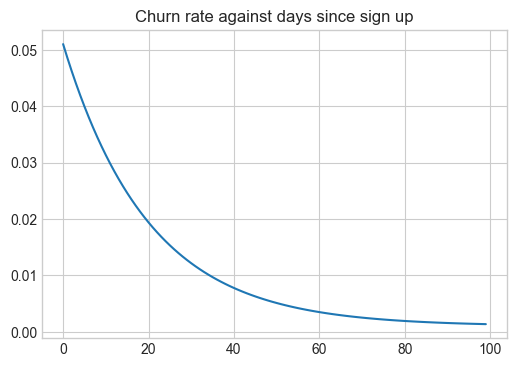

In [2]:
x = np.arange(100)
y = churn_rate_per_day(x)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x=x, y=y, ax=ax)
ax.set(title="Churn rate against days since sign up")
fig.show()

We see the days until churn reduce in proportion as customers stay longer, using the empical CDF:

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_60909/4179589568.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


customer_id,days_until_churn,observed
i64,i64,bool
0,90,false
1,90,false
2,90,false
3,90,false
4,31,true
…,…,…
995,90,false
996,48,true
997,8,true


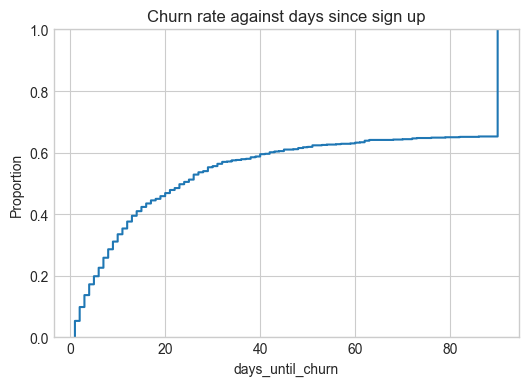

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.ecdfplot(data=train_df, x="days_until_churn", ax=ax)
ax.set(title="Churn rate against days since sign up")
fig.show()
df

For survival modeling we can use the [lifelines package](https://lifelines.readthedocs.io/en/latest/index.html).

We can plot the empirical CDF as the life times for each customer via the lifelines package, where all blue customers have not yet churned as of 90 days.:

/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/lifelines/plotting.py:773: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_60909/661472789.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


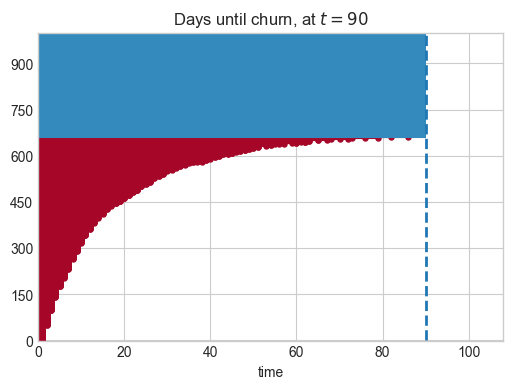

In [4]:
from lifelines.plotting import plot_lifetimes

CURRENT_TIME = 90
fig, ax = plt.subplots(figsize=(6, 4))
plot_lifetimes(df["days_until_churn"], event_observed=df["observed"], ax=ax)
ax.set_xlim(0, CURRENT_TIME * 1.2)
ax.vlines(CURRENT_TIME, 0, n_customers, lw=2, linestyles="--")
ax.set_xlabel("time")
ax.set_title(f"Days until churn, at $t={CURRENT_TIME}$")
fig.show()

### Non parametric estimators
To make statistical inferences, we want to estimate the survival function, $S(t)$, from the collected data.

A univariate way is the Kaplan Meier estimator. This is a non-parametric estimator, for which the estimator mean is the same as the empirical inverse CDF:

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_60909/326303029.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


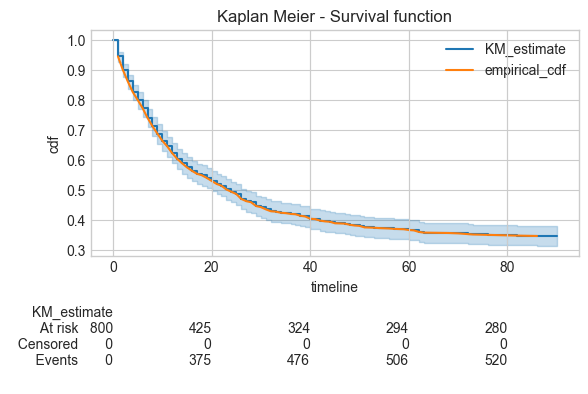

In [5]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations=train_df["days_until_churn"], event_observed=train_df["observed"])

empirical_cdf = (
    train_df.group_by("days_until_churn")
    .len()
    .sort("days_until_churn")
    .with_columns(
        ((len(train_df) - (pl.col("len").cum_sum())) / len(train_df)).alias("cdf")
    )
    .filter(pl.col("days_until_churn") < 90)
)

fig, ax = plt.subplots(figsize=(6, 4))
kmf.plot_survival_function(at_risk_counts=True, ax=ax)
sns.lineplot(
    data=empirical_cdf, x="days_until_churn", y="cdf", ax=ax, label="empirical_cdf"
)
ax.set(title="Kaplan Meier - Survival function")
fig.show()

The estimator variance increases over timeline as we fewer customers at higher days until churn as days increase.

Similarly, to estimate the cumulative Hazards function, $H(t)$, we can use the Nelson Aalan estimator:

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_60909/1938030963.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


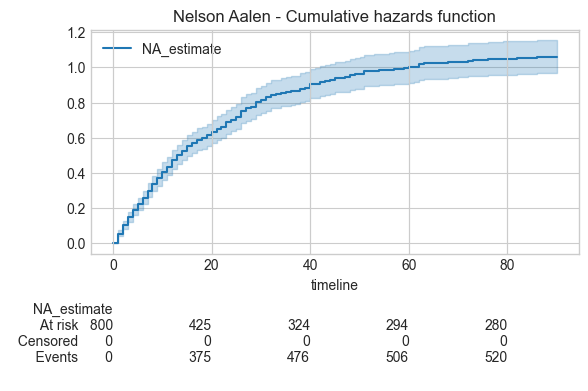

In [6]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(durations=train_df["days_until_churn"], event_observed=train_df["observed"])

fig, ax = plt.subplots(figsize=(6, 4))
naf.plot_cumulative_hazard(at_risk_counts=True, ax=ax)
ax.set(title="Nelson Aalen - Cumulative hazards function")
fig.show()

### Parametric models
The above estimators are non-parametric, they assume no functional form.
This limits their ability to learn the hazards function at any time point given knowledge or other time points and also it limits the abilitiy to extrapolate past 90 days.

Examples of parametric survival estimators include the Weibull and exponential distributions. We can fit the distribution parameters and then extrapolate to longer time horizons.

In [7]:
from lifelines import WeibullFitter, ExponentialFitter

wf = WeibullFitter().fit(
    durations=train_df["days_until_churn"],
    event_observed=train_df["observed"],
    timeline=np.arange(150),
)
exf = ExponentialFitter().fit(
    durations=train_df["days_until_churn"],
    event_observed=train_df["observed"],
    timeline=np.arange(150),
)

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_60909/1596966498.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


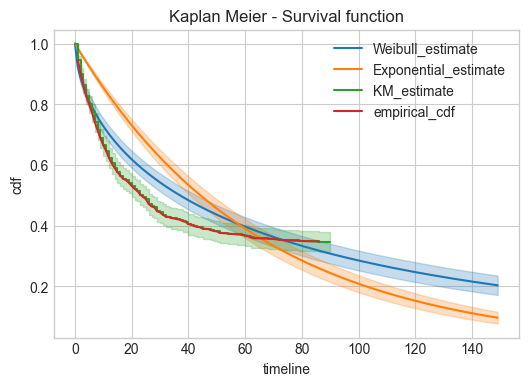

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
wf.plot_survival_function(ax=ax)
exf.plot_survival_function(ax=ax)

kmf.plot_survival_function(ax=ax)
sns.lineplot(
    data=empirical_cdf, x="days_until_churn", y="cdf", ax=ax, label="empirical_cdf"
)
ax.set(title="Kaplan Meier - Survival function")
fig.show()

Note the distribution choice strongly reflects how well it fits the observed data, so any extrapolation is dependent on how well the distribution assumptions reflect the data generating process.
For example here, neither Weibull or exponential distributions fit that well. The exponential distribution assumes a constant hazard rate against time ($h(t)=\frac{1}{\lambda}$).
Our churn rate/hazard rate reduces over time, so an exponential distribution will be a poor fit for this.

Given our knowledge of the ground truth hazard function we can create the same distribution and fit through lifelines.
We use the cumulative hazards function derived above.
Lifelines fits the distribution parameters through the scipy optimize function:

In [9]:
from lifelines.fitters import ParametricUnivariateFitter

import autograd.numpy as np


class ExponentialHazardFitter(ParametricUnivariateFitter):
    _fitted_parameter_names = ["alpha_0_", "alpha_1_"]
    _bounds = [(0, None), (0, None)]

    def _cumulative_hazard(self, params, times):
        alpha_0, alpha_1 = params[0], params[1]
        return alpha_0 - np.exp(-times / alpha_1) + 1


ehf = ExponentialHazardFitter().fit(
    durations=train_df["days_until_churn"],
    event_observed=train_df["observed"],
    timeline=np.arange(200),
)
print("fitted parameters:")
print(ehf.alpha_0_, ehf.alpha_1_)

fitted parameters:
1.0000000000000023e-09 21.837275241776833


/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/lifelines/fitters/__init__.py:1011: ApproximationWarning: 
The Hessian for ExponentialHazardFitter's fit was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


The distribution (green) fits reasonably well to the original parameters of (0.001 and 20). We can see this in an improve survival function and cumulative hazards function:

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_60909/2545171641.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


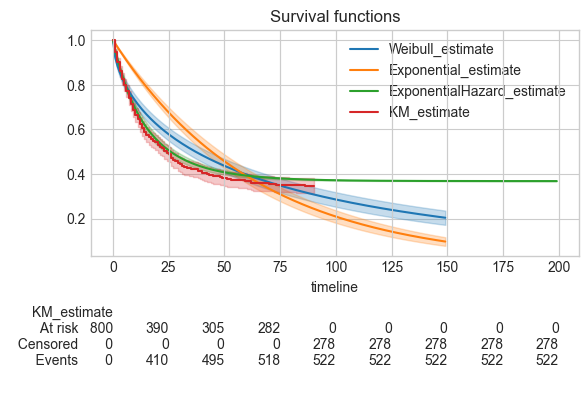

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
wf.plot_survival_function(ax=ax)
exf.plot_survival_function(ax=ax)
ehf.plot_survival_function(ax=ax)

kmf.plot_survival_function(at_risk_counts=True, ax=ax)
ax.set(title="Survival functions")
fig.show()

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_60909/1079980104.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


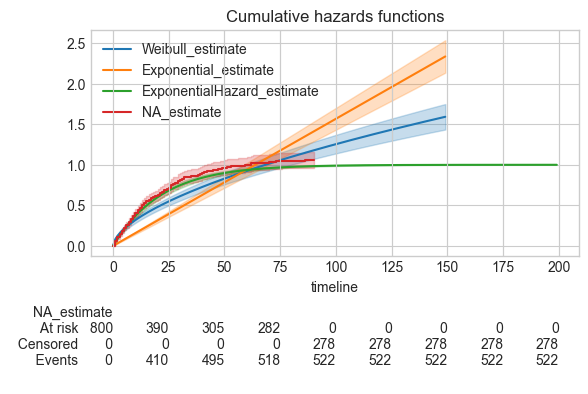

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
wf.plot_cumulative_hazard(ax=ax)
exf.plot_cumulative_hazard(ax=ax)

ehf.plot_cumulative_hazard(ax=ax)
naf.plot_cumulative_hazard(at_risk_counts=True, ax=ax)
ax.set(title="Cumulative hazards functions")
fig.show()

The survival and cumulative hazard functions match much closer to the empirical data.

## Survival regression

For building hazards that are conditioned on covariates we can use the Cox proportional hazards model, which uses the following form:
$$
h(t|x) = b_0(t) \exp({\beta x})
$$

It is made up of a base hazard rate and an exponential term which creates a ratio.
We are measuring the proportional change in hazards due to covariates.

Lifelines requires a dataset with duration and event columns and covariates.
For rows with an observed event the duration corresponds to the time of the event.
For rows without an observed event yet, the duration corresponds to the lifetime so far.

In the following dataset, these are represented by the week (duration) and arrest (event) columns:

In [12]:
from lifelines.datasets import load_rossi

rossi = load_rossi()
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


The Cox model is fit as:

In [13]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(rossi, duration_col="week", event_col="arrest", show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 5.09e-01, step_size = 0.9500, log_lik = -675.38063, newton_decrement = 1.68e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.39e-01, step_size = 0.9500, log_lik = -659.79004, newton_decrement = 9.92e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.80e-02, step_size = 0.9500, log_lik = -658.76197, newton_decrement = 1.42e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.83e-04, step_size = 1.0000, log_lik = -658.74766, newton_decrement = 1.32e-06, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.97e-08, step_size = 1.0000, log_lik = -658.74766, newton_decrement = 1.34e-14, seconds_since_start = 0.0
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-02-26 15:51:06 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

We should check the assumptions of the Cox's model are applicable here.

We not that there are issues in applying to this dataset.
I will ignore this for now to focus on the use of the lifelines library.

In [14]:
cph.check_assumptions(rossi)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

[]

We can show the predicted baseline hazard.
The baseline hazard is only fit to the max duration in the dataset.
It does not get extrapolated.

<Axes: >

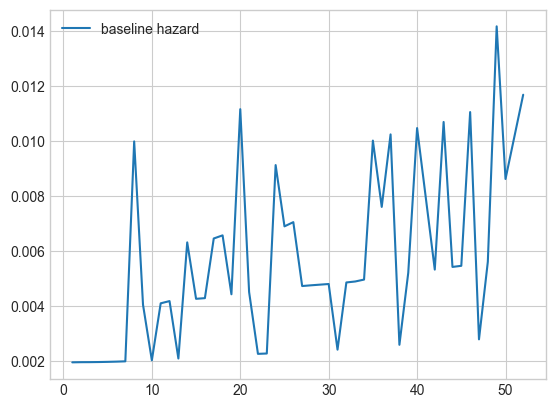

In [15]:
cph.baseline_hazard_.plot()

We can predict survival at different time horizons.
This is predicted for all durations that were available in the dataset.
It can be conditioned on each row's lifetime so far to get survival rates for subsequent time frames.

In [16]:
cph.predict_survival_function(
    rossi.head(5), conditional_after=rossi.head()["week"]
).transpose()  # survival rates at weeks after their current lifetime
cph.predict_survival_function(
    rossi.head(5), times=[0, 10, 30, 52], conditional_after=[0] * 5
).transpose()  # survival rates conditioned on 0 current lifetime, evaluated at given time frames
cph.predict_survival_function(rossi.head(5), times=[0, 10, 30, 52]).transpose()
cph.predict_survival_function(rossi.head(5)).transpose()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,52.0
0,0.997616,0.995230,0.992848,0.990468,0.988085,0.985699,0.983305,0.971402,0.966614,0.964223,...,0.784733,0.774567,0.769460,0.764349,0.754116,0.751552,0.746427,0.733641,0.725969,0.715699
1,0.993695,0.987411,0.981162,0.974941,0.968739,0.962552,0.956370,0.926001,0.913958,0.907978,...,0.526079,0.508214,0.499383,0.490641,0.473429,0.469176,0.460745,0.440128,0.428038,0.412181
2,0.994083,0.988183,0.982314,0.976468,0.970639,0.964820,0.959004,0.930402,0.919043,0.913399,...,0.547334,0.529874,0.521230,0.512664,0.495770,0.491589,0.483296,0.462975,0.451031,0.435335
3,0.999045,0.998089,0.997133,0.996176,0.995216,0.994254,0.993287,0.988460,0.986508,0.985531,...,0.907577,0.902855,0.900469,0.898071,0.893242,0.892026,0.889587,0.883460,0.879752,0.874752
4,0.997626,0.995250,0.992878,0.990507,0.988135,0.985758,0.983374,0.971520,0.966752,0.964370,...,0.785530,0.775396,0.770304,0.765209,0.755007,0.752451,0.747341,0.734592,0.726942,0.716702


We can show the effect of covariates on the survival function:

<Axes: >

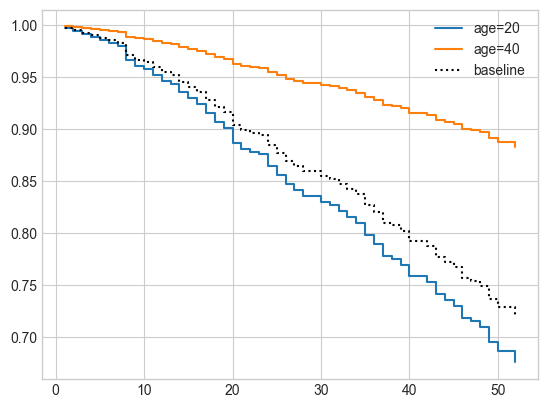

In [17]:
cph.plot_partial_effects_on_outcome(covariates="age", values=[20, 40])